Wine Quality dataset

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
sns.set_palette('icefire')

Read data

In [2]:
data_dir = '../data/raw'
dest_data_dir = '../data/processed'
seed = 42

In [3]:
red_df = pd.read_csv(f'{data_dir}/winequality-red.csv', sep = ';')
white_df = pd.read_csv(f'{data_dir}/winequality-white.csv', sep = ';')
red_df['type'] = 0
white_df['type'] = 1

df = pd.concat([red_df, white_df], axis = 0)
df.reset_index(inplace = True, drop = True)
df.shape

(6497, 13)

In [4]:
red_df.shape, white_df.shape

((1599, 13), (4898, 13))

In [5]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


In [6]:
df['quality'].value_counts() / len(df)

quality
6    0.436509
5    0.329075
7    0.166077
4    0.033246
8    0.029706
3    0.004618
9    0.000770
Name: count, dtype: float64

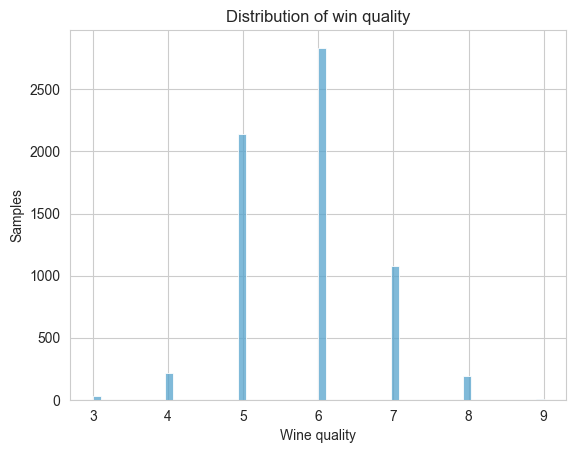

In [7]:
sns.histplot(data = df, x = 'quality')
plt.xlabel('Wine quality')
plt.ylabel('Samples')
plt.title('Distribution of win quality')
plt.show()

In [8]:
df['quality'].mean(), df['quality'].std()

(5.818377712790519, 0.8732552715311248)

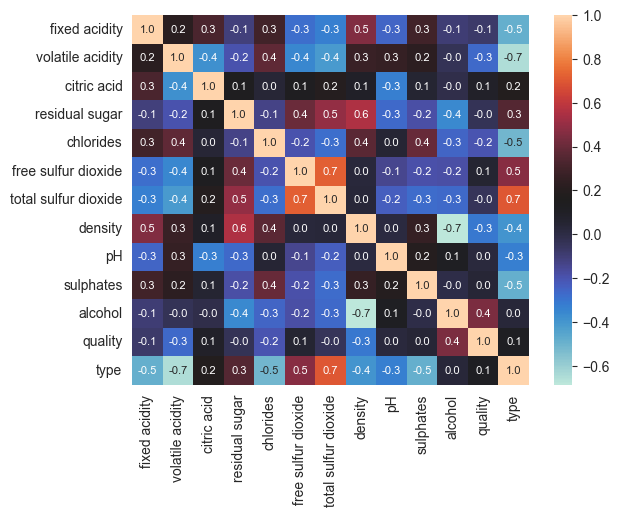

In [9]:
corr = df.corr()
sns.heatmap(corr, annot = True, cmap = 'icefire', fmt = '.1f', annot_kws={"fontsize":8})
plt.show()

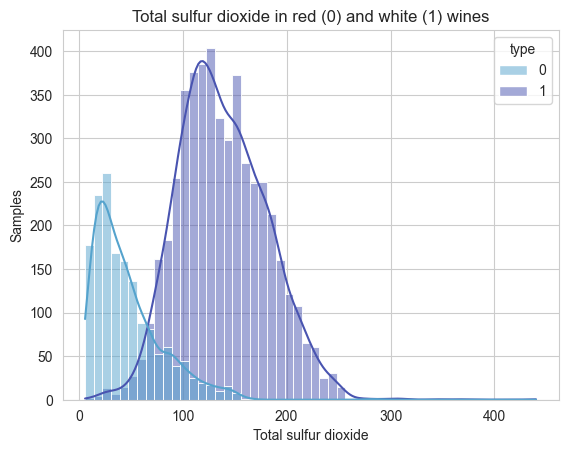

In [10]:
sns.histplot(data = df, x = 'total sulfur dioxide', hue = 'type', kde = True)
plt.xlabel('Total sulfur dioxide')
plt.ylabel('Samples')
plt.title('Total sulfur dioxide in red (0) and white (1) wines')
plt.show()

Split dataset into folds

In [11]:
from sklearn.model_selection import StratifiedKFold
import random
random.seed = seed

In [12]:
## Split k-fold
# shuffle
df = df.sample(frac = 1, random_state = seed).reset_index(drop = True)
df['kfold'] = -1

# split into multiple folds
kf = StratifiedKFold(n_splits=6, random_state=seed, shuffle=True)            # 5-folds

# populate the fold column
y = df['quality']
for fold, (train_idx, valid_idx) in enumerate(kf.split(X=df, y=y), start = 1):
    df.loc[valid_idx, 'kfold'] = fold

### Data preprocessing
We are treating the problem as regression

In [13]:
from sklearn.preprocessing import RobustScaler

# scaler for features
x_scaler = RobustScaler()
cols = [c for c in df.columns if c not in ['quality', 'kfold']]
x_scaler.fit(df[cols].values)
df[cols] = x_scaler.transform(df[cols].values)

# scaler for target
y_scaler = RobustScaler()
y_scaler.fit(df[['quality']].values.flatten().reshape(-1, 1))
df['quality'] = y_scaler.transform(df[['quality']].values.flatten().reshape(-1, 1))

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type,kfold
0,0.000000,-0.705882,3.071429,1.555556,-0.074074,-0.208333,0.101266,-0.148387,0.238095,-0.764706,1.055556,2.0,0.0,2
1,0.538462,2.058824,-0.714286,-0.126984,1.111111,0.125000,0.189873,0.152688,0.285714,-0.352941,-0.222222,-1.0,-1.0,6
2,-0.153846,0.588235,0.214286,0.698413,-1.000000,0.375000,0.189873,-0.595699,-0.142857,-0.411765,0.944444,1.0,0.0,6
3,-0.538462,-0.058824,1.142857,1.301587,-0.259259,1.333333,0.822785,0.221505,-0.428571,0.000000,-0.444444,0.0,0.0,2
4,0.307692,0.352941,-0.785714,1.730159,0.259259,1.416667,1.405063,0.858065,-0.476190,-0.058824,-0.777778,0.0,0.0,3


In [14]:
cols

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'type']

In [15]:
###
# fold 1-5 will be used for training
# fold 6 will be used for testing
train_df = df[df['kfold'] != 6]
test_df = df[df['kfold'] == 6]

# save the dataset
train_df.to_csv(f'{dest_data_dir}/train.csv')
test_df.to_csv(f'{dest_data_dir}/test.csv')

train_df.shape, test_df.shape

((5415, 14), (1082, 14))

### Modeling
Since we are using decision tree for classification model, we don't need scaling

In [16]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse

In [17]:
results = {}
for fold in [1, 2, 3, 4, 5]:
    X_train = train_df[train_df['kfold'] != fold].drop(columns = ['quality', 'kfold']).values
    y_train = train_df[train_df['kfold'] != fold]['quality'].values
    X_test= train_df[train_df['kfold'] == fold].drop(columns = ['quality', 'kfold']).values
    y_test = train_df[train_df['kfold'] == fold]['quality'].values
    model = GradientBoostingRegressor(n_estimators=1000, subsample = 0.8, learning_rate = 0.05, random_state = seed,
                                    criterion = 'squared_error', min_samples_split = 10, max_depth = 10)
    model.fit(X_train, y_train)
    train_mse = mse(y_train, model.predict(X_train))
    test_mse = mse(y_test, model.predict(X_test))
    results[fold] = {'train_mse': train_mse, 'test_mse': test_mse}

In [18]:
results

{1: {'train_mse': 5.899344319681994e-07, 'test_mse': 0.35693734436622715},
 2: {'train_mse': 2.478011451239452e-07, 'test_mse': 0.3684798470632959},
 3: {'train_mse': 4.080316094885012e-07, 'test_mse': 0.3716029294245354},
 4: {'train_mse': 4.2092996270884325e-07, 'test_mse': 0.41104281336524295},
 5: {'train_mse': 5.529440018820606e-07, 'test_mse': 0.3965527048420788}}

In [19]:
mean_train_mse = np.mean([r['train_mse'] for _, r in results.items()])
mean_test_mse = np.mean([r['test_mse'] for _, r in results.items()])
print(f'Mean train mse: {round(mean_train_mse, 4)}')
print(f'Mean test mse: {round(mean_test_mse, 4)}')

Mean train mse: 0.0
Mean test mse: 0.3809


Train on full train data

In [20]:
X_train = train_df.drop(columns = ['quality', 'kfold']).values
y_train = train_df['quality'].values
X_test= test_df.drop(columns = ['quality', 'kfold']).values
y_test = test_df['quality'].values
model = GradientBoostingRegressor(n_estimators=1000, subsample = 0.8, learning_rate = 0.05, random_state = seed,
                                criterion = 'squared_error', min_samples_split = 10, max_depth = 10)
model.fit(X_train, y_train)
train_mse = mse(y_train, model.predict(X_train))
test_mse = mse(y_test, model.predict(X_test))
print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

Train MSE: 2.548377227961227e-06
Test MSE: 0.36500277394027125


Save

In [21]:
import pickle
import joblib

model_dest = '../models/gradient_boosting'
os.makedirs(model_dest, exist_ok=True)

## Save scalers and model
with open(f'{model_dest}/features_scaler.pkl', 'wb') as f:
    pickle.dump(x_scaler, f)
    
with open(f'{model_dest}/target_scaler.pkl', 'wb') as f:
    pickle.dump(y_scaler, f)
    
joblib.dump(model, f'{model_dest}/model.joblib')

['../models/gradient_boosting/model.joblib']